In [2]:
'''
  File: SensorDriftAnalysis.ipynb
  Description: Observing before and after cases of sensor drift.
  Author: Johnathan Evans
  Created: 05/30/2023
  Updated: ...
'''
#imports
import numpy as np
import pandas as pd
import scipy as sc
import scipy.stats as st
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import f
import statsmodels.api as sm
import matplotlib.pyplot as plt
import csv

"Borrowed"
def selectPeriods(df, delta_t):
    pointer = 5
    endSpots = []
    setPoints = []
    while pointer < len(df) - 3:
        if (int(df.loc[pointer, 'Target ppm']) - int(df.loc[pointer - 1, 'Target ppm'])) != 0:
            endSpots.append(pointer - 1)
            pointer += 1
        else:
            pointer += 1
    endSpots.append(len(df) - 3)
    for item in endSpots:
        setPoints.append([item - delta_t, item])
    return setPoints


In [3]:
# Funk Equation - Borrowed from colleague

# Load data from CSV file
file2 = pd.read_csv("../Output/BenSummaryJustMatrix.csv")

# Extract the columns from the data
xDataResistance = file2.loc[:, 'Resistance']
xDataRatio = file2.loc[:, 'Ratio']
xDataRH = file2.loc[:, 'RelativeHumidity']
xDataTemp = file2.loc[:, 'Temperature']
yDataTargetPPM = file2.loc[:, 'Target PPM']

# Separate the independent and dependent variables
X = file2.drop('Target PPM', axis='columns')
y = file2.loc[:, 'Target PPM']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#+ g * np.exp(-1 * T*h + i)
def funct3(X, a, b, c, d, e,f,j):
    R, H, T = X
    return a * np.exp(-1 * R*b + c)+ d * np.exp(-1 * H*e + f) + j
p0 = 1,1,.5,1,1,1,1

# Perform curve fitting using the funct function, xDataResistance, and yDataTargetPPM data
# Set the maximum number of function evaluations to 1000000
popt, pcov = sc.optimize.curve_fit(funct3, (xDataResistance,xDataRH, xDataTemp), yDataTargetPPM,p0, maxfev=1000000)

# Print the optimized parameters
#print(popt)


y_pred = funct3((xDataResistance,xDataRH, xDataTemp), *popt)
print('R-squared: ', r2_score(y, y_pred))

# Calculate residuals
residuals = y - y_pred

# Reshape your input data to fit the het_breuschpagan function requirements
exog = np.vstack((xDataResistance, xDataRH, xDataTemp)).T

# Extract the Resistance column from the X_test dataframe
R_test = X_test.loc[:, 'Resistance']
H_test = X_test.loc[:, 'RelativeHumidity']
T_test = X_test.loc[:, 'Temperature']

# Generate the predictions using the optimized parameters and the input data
y_pred = funct3((R_test,H_test, T_test), *popt)

# Calculate the mean squared error
testVal = mean_squared_error(y_test, y_pred, squared=False)
print('Stdev: ',testVal)

R-squared:  0.9425809732518944
Stdev:  77.37755361004317


/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_59158/1091745471.py:24: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-1 * R*b + c)+ d * np.exp(-1 * H*e + f) + j
/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_59158/1091745471.py:24: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-1 * R*b + c)+ d * np.exp(-1 * H*e + f) + j


file1
file2


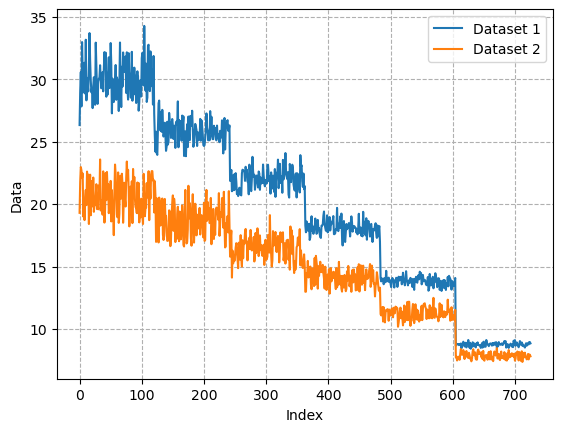

In [4]:
# Define the function to extract data
def extract_data(filename):
    pdadata = pd.read_csv(filename)
    indexes = selectPeriods(pdadata, 120)
    data=pd.DataFrame()
    for i in range(0, len(indexes)):
        data2 = pdadata.loc[indexes[i][0]:indexes[i][1],:]
        data=pd.concat([data,data2], ignore_index=True)
    Vout = data.iloc[:, 4].astype(float)
    Vref = data.iloc[:, 20].astype(float)
    extracted_data = (Vref * (5 - Vout)) / (Vout * (5 - Vref))
    return data, extracted_data

# Read and extract data from the first CSV file
file1 = 'JohnathanDataStorage/0C%5Best.csv'
print("file1")
df1,data1 = extract_data(file1)

# Read and extract data from the second CSV file
file2 = 'JohnathanDataStorage/0C%5Re.csv'
print("file2")
df2,data2 = extract_data(file2)
data2=data2*1.0
# Plot the datasets against each other
plt.plot(data1, label='Dataset 1')
plt.plot(data2, label='Dataset 2')

# Include horizontal gridlines
plt.grid(True, linestyle='--')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Data')
plt.legend()

# Display the plot
plt.show()

In [8]:
target_ppm = df1['Target ppm']
extracted_data1 = data1.groupby(target_ppm).mean()
target_ppm2 = df2['Target ppm']
extracted_data2 = data2.groupby(target_ppm2).mean()
data_diff=extracted_data1/extracted_data2

print(extracted_data1/extracted_data2)

Target ppm
0     1.451559
2     1.379599
5     1.338084
10    1.283503
20    1.228191
50    1.114560
dtype: float64


Fitted function parameters: a=0.330, b=0.056, c=1.101


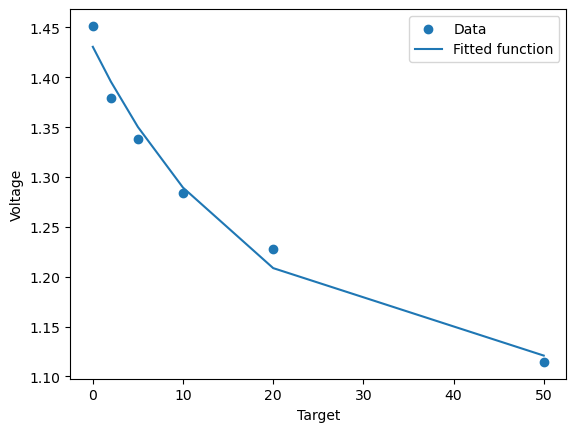

In [9]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Given data
data = {'Target': [0, 2, 5, 10, 20, 50],
        'Voltage': [1.451559, 1.379599, 1.338084, 1.283503, 1.228191, 1.114560]}
df = pd.DataFrame(data)

# Define the function to be fit to the data
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Use curve_fit to fit the defined function to the data
params, params_covariance = curve_fit(exp_func, df['Target'], df['Voltage'])

# Print the parameters of the fitting function
print('Fitted function parameters: a=%.3f, b=%.3f, c=%.3f' % (params[0], params[1], params[2]))

# Use the fitted parameters to generate y data from the function
y_fit = exp_func(df['Target'], params[0], params[1], params[2])

# Plot the original data as points
plt.scatter(df['Target'], df['Voltage'], label='Data')

# Plot the fitted function as a line
plt.plot(df['Target'], y_fit, label='Fitted function')

# Add labels and legend
plt.xlabel('Target')
plt.ylabel('Voltage Ratio')
plt.legend()

# Display the plot
plt.show()


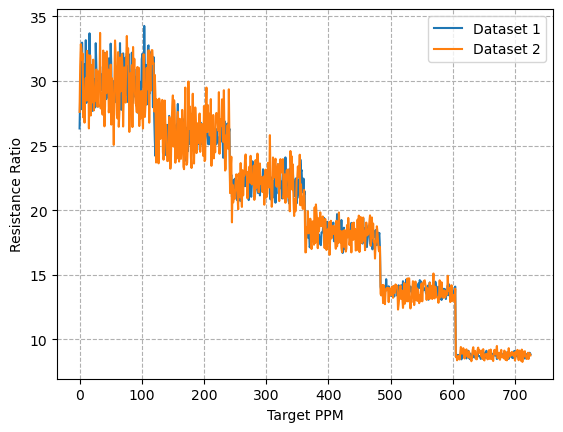

In [12]:
# Plotting the Data after normalization
normalization2 = exp_func(target_ppm2,*params)
data2=data2*normalization2
plt.plot(data1, label='Dataset 1')
plt.plot(data2, label='Dataset 2')

# Include horizontal gridlines
plt.grid(True, linestyle='--')

# Add labels and legend
plt.xlabel('Target PPM')
plt.ylabel('Resistance Ratio')
plt.legend()

# Display the plot
plt.show()

In [13]:
# Making the resistance ratio easier to access and manage
for s in range(0, 16):
    tempResistance = (df1['Vref' + str(s)] * (5 - df1['Vout' + str(s)])) / (
            (df1['Vout' + str(s)]) * (5 - df1['Vref' + str(s)]))
    tempFrame = pd.DataFrame(tempResistance, columns=['Resistance' + str(s)])
    df1 = pd.concat([df1, tempFrame], axis=1)

for s in range(0, 16):
    tempResistance = (df2['Vref' + str(s)] * (5 - df2['Vout' + str(s)])) / (
            (df2['Vout' + str(s)]) * (5 - df2['Vref' + str(s)]))
    tempFrame = pd.DataFrame(tempResistance, columns=['Resistance' + str(s)])
    df2 = pd.concat([df2, tempFrame], axis=1)

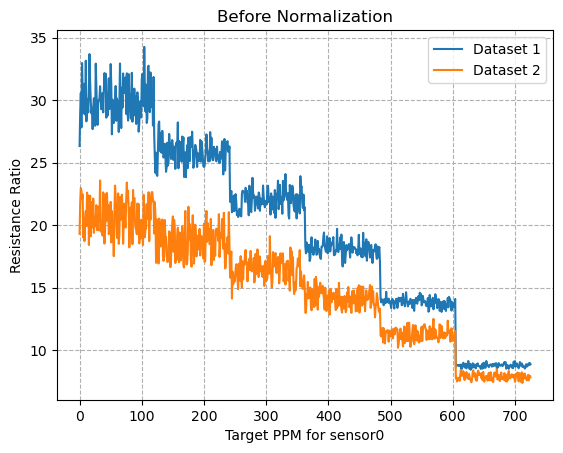

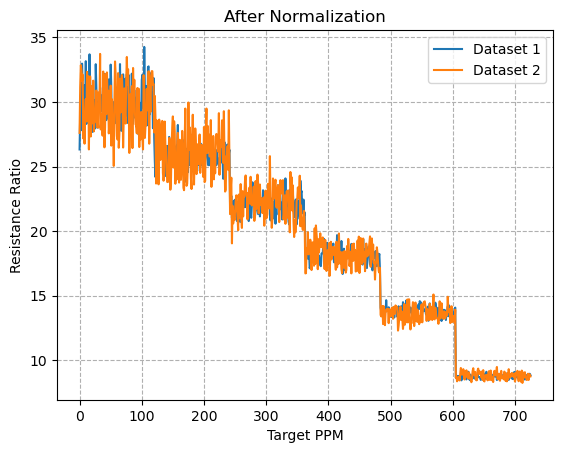

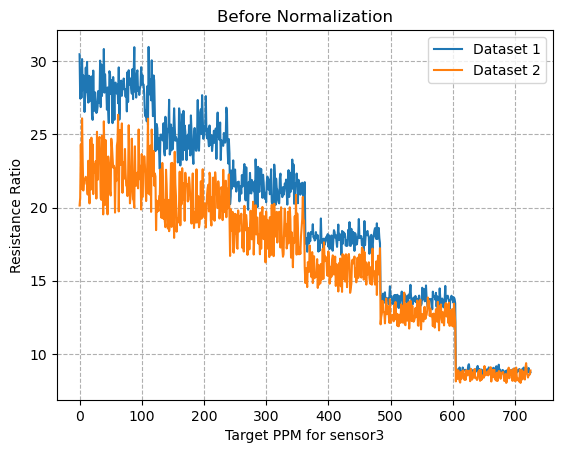

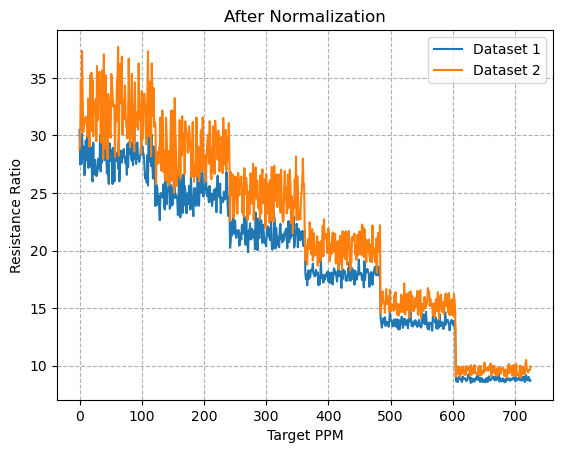

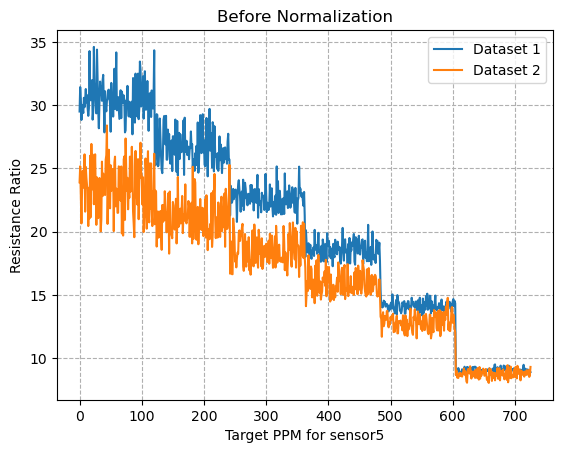

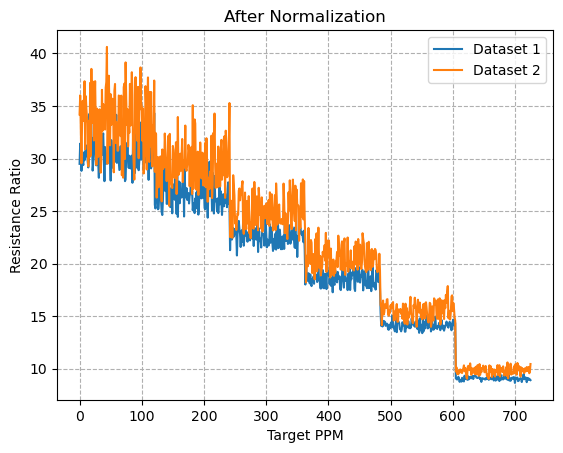

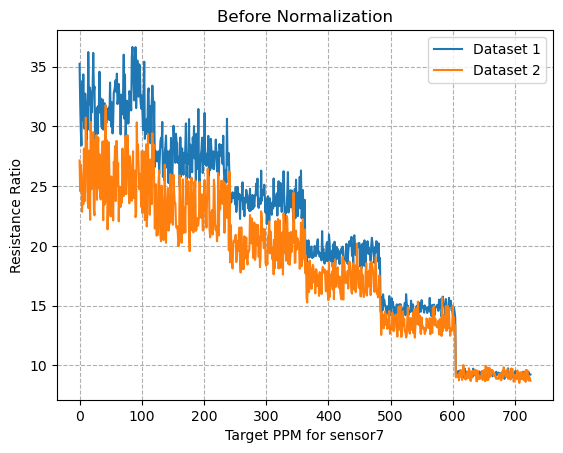

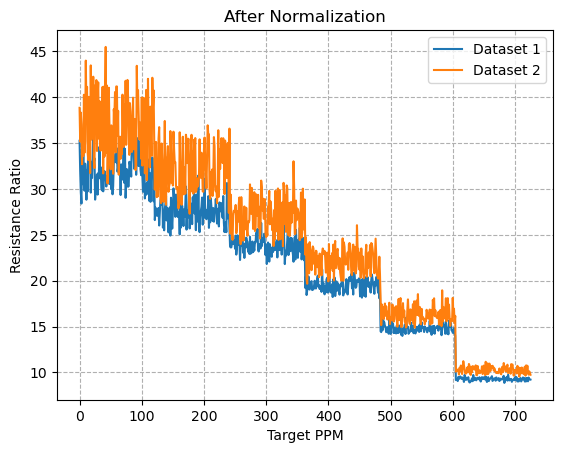

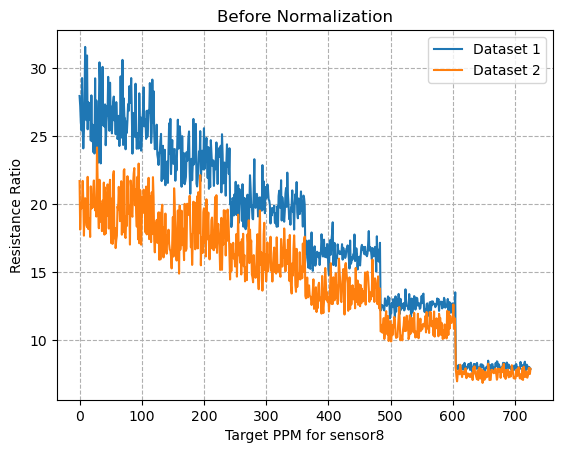

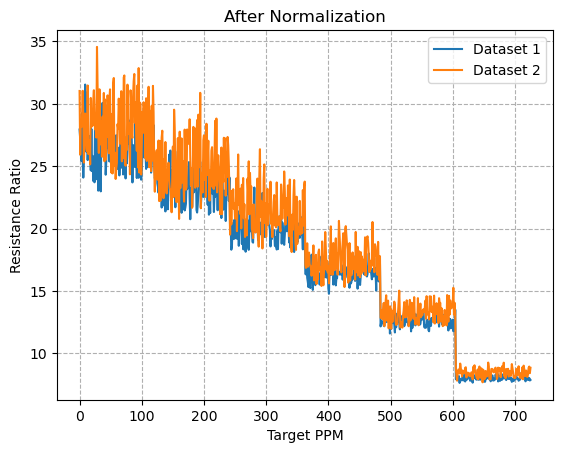

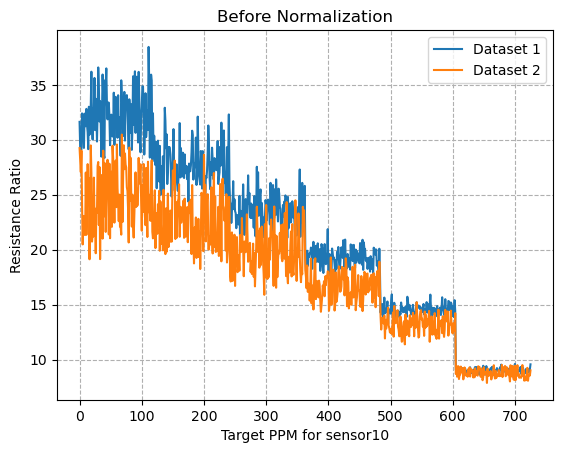

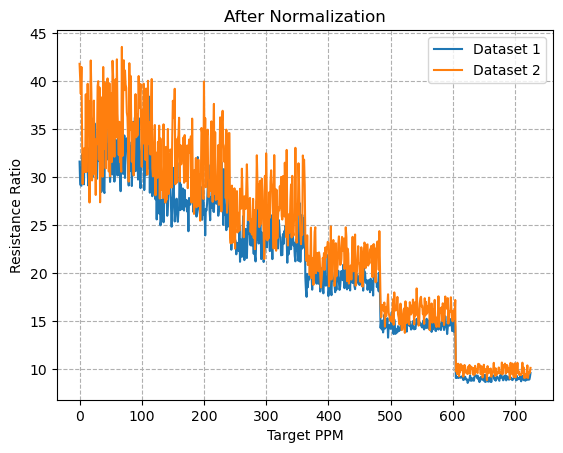

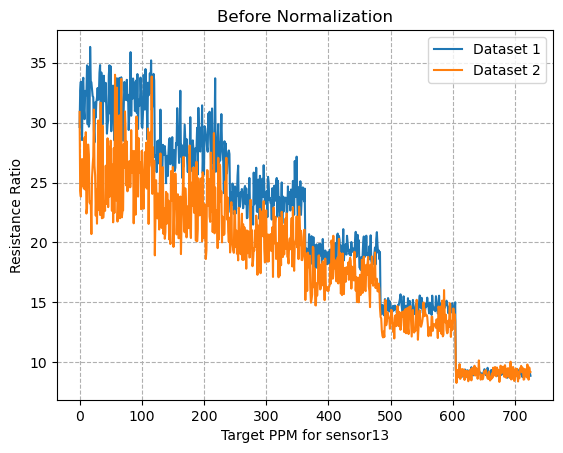

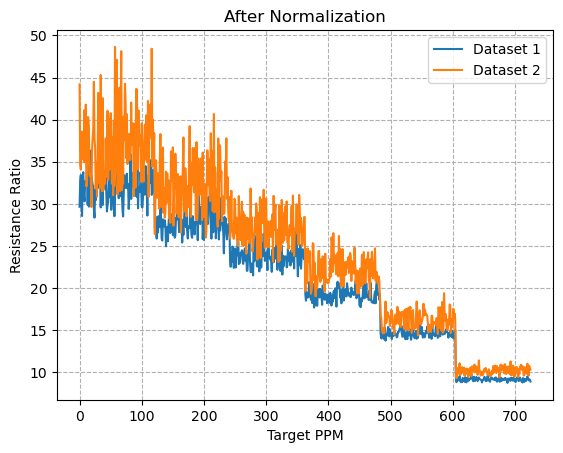

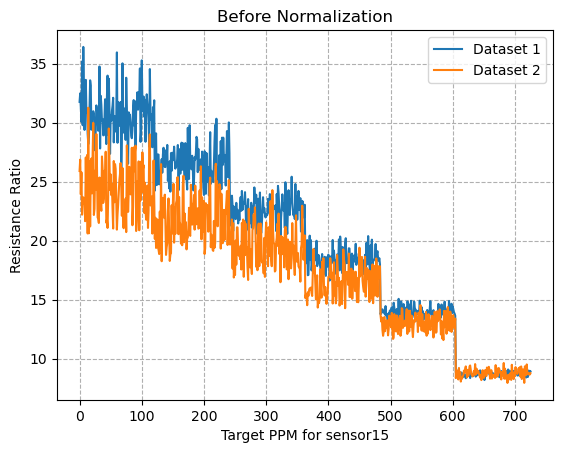

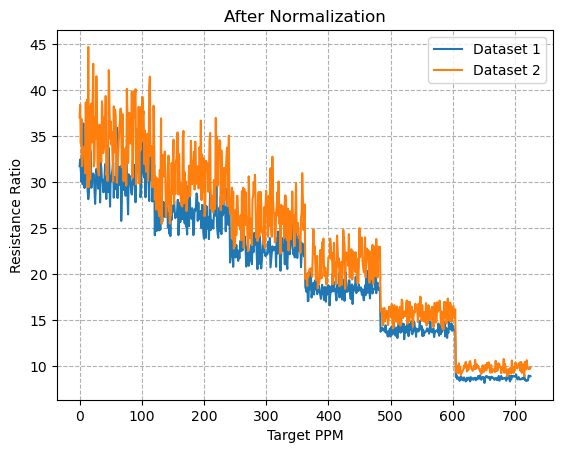

In [17]:
for s in [0,3,5,7,8,10,13,15]:
    plt.plot(df1['Resistance' + str(s)], label='Dataset 1')
    plt.plot(df2['Resistance' + str(s)], label='Dataset 2')

# Include horizontal gridlines
    plt.grid(True, linestyle='--')

# Add labels and legend
    plt.xlabel('Target PPM for sensor'+ str(s))
    plt.ylabel('Resistance Ratio')
    plt.title('Before Normalization')
    plt.legend()
    plt.show()

    normalization2 = exp_func(target_ppm2,*params)
    data2=df2['Resistance' + str(s)]*normalization2
    plt.plot(df1['Resistance' + str(s)], label='Dataset 1')
    plt.plot(data2, label='Dataset 2')

# Include horizontal gridlines
    plt.grid(True, linestyle='--')

# Add labels and legend
    plt.xlabel('Target PPM')
    plt.ylabel('Resistance Ratio')
    plt.title('After Normalization')
    plt.legend()

# Display the plot
    plt.show()
